# Audio Data Processing in Python

- Reference:
    - [Audio Deep Learning Made Simple - Why Mel Spectrograms perform better](https://ketanhdoshi.github.io/Audio-Mel/)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

import IPython.display as ipd

from itertools import cycle
from pathlib import Path
from typing import Tuple

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [4]:
data_path = Path("__file__").resolve().parents[1] / 'data' / 'ml-class' / 'cnn-audio'
audio_files = data_path.glob('*/*.wav')

## Reading in Audio Files
### Audio File Formats and Python Libraries
- There are many types of audio files: `mp3`, `wav`, `m4a`, `flac`, `ogg`
- Python has some great libraries for audio processing: 
    - `Librosa` is one of the most popular and has an extensive set of features. 
    - `torchaudio` that is tightly integrated with Pytorch. 
        - It doesn’t have as much functionality as Librosa, but it is built specifically for deep learning.


In [5]:
audio_file = next(audio_files)

In [6]:
# Play audio file
ipd.Audio(audio_file)

In [7]:
y, sr = librosa.load(audio_file) # y: raw audio file, and sr: sample rate

### Audio Signal Data
- Audio data is obtained by sampling the sound wave at regular time intervals and measuring the intensity or amplitude of the wave at each sample
- Audio is saved in a file it is in a compressed format. When the file is loaded, it is decompressed and converted into a Numpy array. 
- In memory, audio is represented as a time series of numbers, representing the **amplitude** at each timestep. 
    - For instance, if the `sample rate` was 22050, a one-second clip of audio would have 22050 numbers
- `Bit-depth`: how many possible values those amplitude measurements for each sample can take. 
    - For example, a bit-depth of 16 means that the amplitude number can be between 0 and 65535 ($2^{16}— 1$)
<p align="center">
  <img src="../assets/img/bit-depth-sample-rate.png" width=400 /><br>
Bit-depth and sample-rate determine the audio resolution
</p>

In [8]:
print(f"y: {y[:10]}")
print(f"y_shape: {y.shape}")
print(f"sample rate: {sr}")

y: [-0.03355648 -0.01779348 -0.00846623 -0.02595853 -0.01094444  0.01503009
  0.00635132 -0.00230753 -0.01424543 -0.03053554]
y_shape: (22050,)
sample rate: 22050


In [9]:
def plot_audio(y: np.ndarray, 
               color: Tuple[float, float, float], 
               title:str, 
               figsize: Tuple[int, int] = (8,4)):
    pd.Series(y).plot(figsize=figsize, 
                  lw=1, 
                  title=title,
                  color=color)
    plt.show()

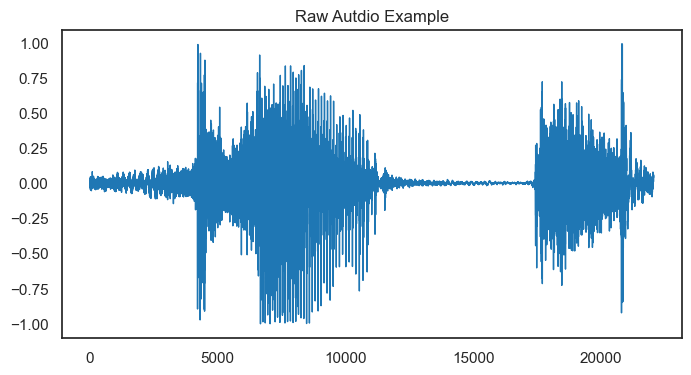

In [10]:
plot_audio(y, color=color_pal[0], title='Raw Autdio Example')

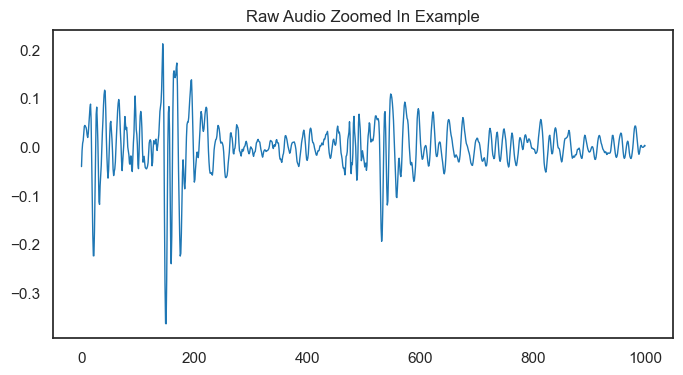

In [11]:
plot_audio(y[11000: 12000], color=color_pal[0], title='Raw Audio Zoomed In Example')

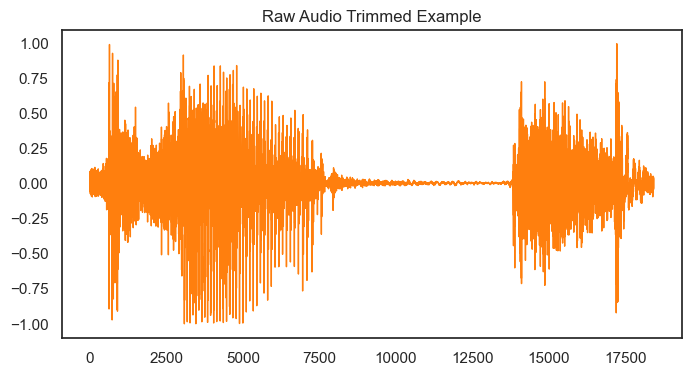

In [12]:
y_trimmed, _ = librosa.effects.trim(y, top_db=15) # limit db to 20
plot_audio(y_trimmed, color_pal[1], "Raw Audio Trimmed Example")

## Spectrogram
- Look at the different frequencies by how powerful they are using Fourier Transform
- Spectrograms are generated from sound signals using Fourier Transforms. 
- A Fourier Transform decomposes the signal into its constituent frequencies and displays the amplitude of each frequency present in the signal.
    - It plots Frequency (y-axis) vs Time (x-axis) and uses different colors to indicate the Amplitude of each frequency.
- *Common practice*: is to convert the audio into a spectrogram as it is an image, it is well suited to being input to CNN-based architectures developed for handling images.

In [13]:
# Compute power spectrogram with Short-time Fourier transform (STFT).
D = librosa.stft(y) 
S_db = librosa.amplitude_to_db(np.abs(D), ref = np.max) # Convert an amplitude spectrogram to dB-scaled spectrogram.
S_db.shape

(1025, 44)

In [14]:
# Plot the transformed audio data
def plot_spectrogram(S_db, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    img = librosa.display.specshow(S_db,
                                x_axis='time',
                                y_axis='log',
                                ax=ax)
    ax.set_title(title)
    fig.colorbar(img, ax=ax, format=f'%0.2f dB')
    plt.show()

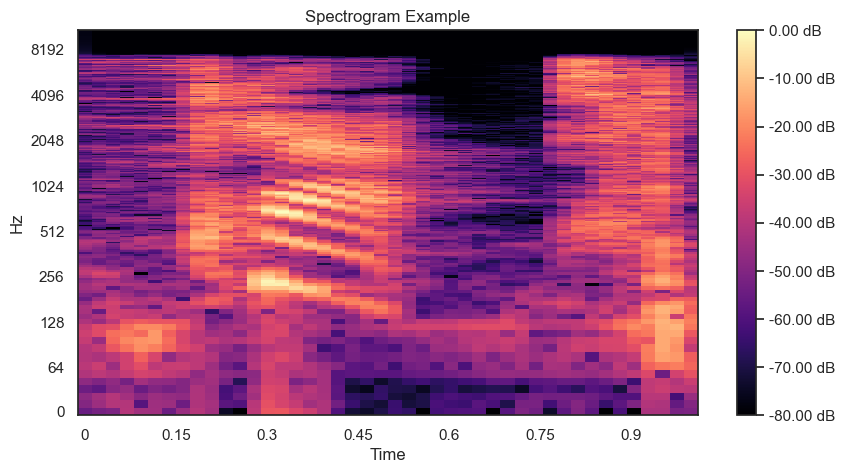

In [15]:
plot_spectrogram(S_db, title='Spectrogram Example')

### Mel Spectrogram 
- A Mel Spectrogram makes two important changes relative to a regular Spectrogram that plots Frequency vs Time.
  - It uses the [Mel Scale](#mel-scale) instead of Frequency on the y-axis.
  - It uses the [Decibel Scale](#decibel-scale) instead of Amplitude to indicate colors.
- Note: For deep learning models, we usually use Mel Spectrogram rather than a simple Spectrogram.



#### How do humans hear frequencies?
- The way we hear frequencies in sound is known as `‘pitch’`.
- A **high-pitched** sound has a **higher** frequency than a low-pitched sound. 
- Humans do **not perceive** frequencies **linearly**.
    - For instance, if you listened to different pairs of sound as follows:
        - 100Hz and 200Hz
        - 1000Hz and 1100Hz
        - 10000Hz and 10100 Hz
    - The actual frequency difference between each pair is exactly the same at 100 Hz. 
    - However,the pair at 100Hz and 200Hz will sound further apart than the pair at 1000Hz and 1100Hz. 
        - And you will hardly be able to distinguish between the pair at 10000Hz and 10100Hz.
    - Reason: if we realize that the 200Hz frequency is actually double the 100Hz, whereas the 10100Hz frequency is only 1% higher than the 10000Hz frequency.
    - We hear them on a **logarithmic** scale rather than a linear scale.

##### Mel Scale
- The Mel Scale was developed to take this into account by conducting experiments with a large number of listeners.
- It is a scale of pitches, such that each unit is judged by listeners to be equal in pitch distance from the next.

<p align="center">
  <img src="../assets/img/mel-scale.png" width=300 /><br>
Mel Scale measures human perception of pitch
</p>

#### How do humans hear amplitudes?
- The human perception of the amplitude of a sound is its loudness. 
- And similar to frequency, we hear **loudness logarithmically** rather than linearly.

##### Decibel Scale
- On this scale, 0 dB is total silence. From there, measurement units increase exponentially. 
- 10 dB is 10 times louder than 0 dB, 
- 20 dB is 100 times louder
- 30 dB is 1000 times louder. 
- Above 100 dB starts to become unbearably loud.
$$ N_{dB} = 10*log_{10}{(\frac{P_1}{P_2})} $$
- Where $P_1$ and $P_2$ the intensity of the two sounds

<p align="center">
  <img src="../assets/img/db-scale.png" width=500 /><br>
Decibel levels of common sounds
</p>

In [16]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

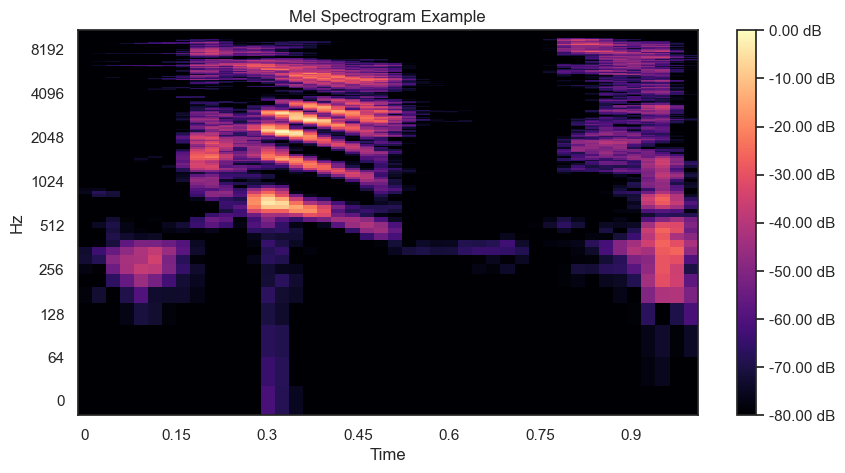

In [17]:
plot_spectrogram(S_db_mel, title='Mel Spectrogram Example')